In [ ]:
!unzip /content/drive/MyDrive/DataSet/KYR_B_imaging.zip

# 사용자 모듈 복사 

In [16]:
!cp '/content/drive/MyDrive/Colab Notebooks/CT분류프로젝트/Custom_Py/init.py' ./

# 데이터 디렉토리 로드 

In [1]:
import os 
import cv2 
import pandas as pd 
from glob import glob
from tqdm import tqdm
from init import init #초기 설정용 커스텀 패키지 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as cm 

## 파일 디렉토리 설정 

In [4]:
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/nswr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6' '/content/KYR_B_imaging' 
!rm -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱'

## 이미지 디렉토리 dir_df 생성 

In [ ]:
#폴더 디렉토리
folder_dir = glob('/content/KYR_B_imaging/*')

dir_df = init.dir_df(folder_dir)

##환자정보- snsb_df 생성 

In [3]:
columns = ['성명',
 '병록번호',
 '만나이',
 '교육년수',
 'SVLT_recall_total_score_z',
 'SVLT_Delayed_recall_z',
 'SVLT_recognition_score_z',
 'RCFT_immediate_recall_z',
 'RCFT_delayed_recall_z',
 'RCFT_recognition_score_z',
 'K_MMSE_total_score_z',
 'SNSB_II_Domain_Attention_z',
 'SNSB_II_Domain_Language_z',
 'SNSB_II_Domain_Visuospatial_z',
 'SNSB_II_Domain_Memory_z',
 'SNSB_II_Domain_Frontal_z']

In [70]:
snsb_df = pd.read_csv('/content/drive/MyDrive/DataSet/202202_김예림/SNSB_integerated.csv')
snsb_df = snsb_df.drop([2098,2591]) #병록번호 없는 행 제거 <- 결측치 
snsb_df['병록번호'] = snsb_df['병록번호'].apply(lambda x : str(int(x)))

snsb_df = snsb_df[columns]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,91,111,142,145,147,257,259,283,284,287,289,322,325,361,362) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 병록번호- key 값 보정

snsb_df,dir_df = key_modify(snsb_df,dir_df,target_length)

plt.hist(snsb_df['병록번호'].map(len))
plt.show()

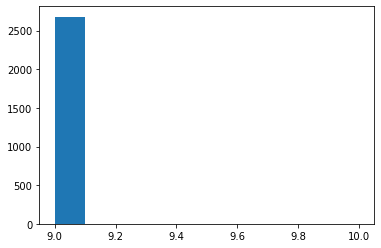

In [71]:
target_length = [4,5,6,7,8] #<- 수정해야 하는 병록번호 갯수들 

#병록 번호의 length 가 target_length에 속하는 것들 모두 0 더해서 9자리로 맞춤 
for length in target_length: 
  difference = 9 - length #추가해줘야 하는 자릿수 
  add = '0' *difference #추가해줘야 하는 자릿수 만큼 0추가 
  
  modified_id = snsb_df.loc[snsb_df['병록번호'].map(len)==length,'병록번호'].apply(lambda x : add+x)
  snsb_df.loc[snsb_df['병록번호'].map(len)==length,'병록번호'] = modified_id

#위 로직으로 보정되지 않은 것들 임베딩으로 보정 아래 dict keys 값들이 보정되지 않은 값임 
mis_keys_dict = {'17043':'170435316','19021':'190215496','20004':'200045636','97026':'970266683','094018957':'940189576'}
mis_keys_keys = list(mis_keys_dict.keys())

#위 mis_keys_dict를 토대로 값 보정 진행 
temp = dir_df.loc[dir_df['key'].apply(lambda x : x in mis_keys_keys),'key'].apply(lambda x:mis_keys_dict[x])
dir_df.loc[dir_df['key'].apply(lambda x : x in mis_keys_keys),'key'] = temp

plt.hist(snsb_df['병록번호'].map(len))
plt.show()

## Key 값 미스매칭 확인 

In [72]:
csv_key = list(set(snsb_df['병록번호']))
img_key = list(set(dir_df['key']))
csv_key.sort()
img_key.sort()
csv_key = np.array(csv_key)
img_key = np.array(img_key)

error = [] 
for i in range(len(img_key)):
  if img_key[i] in csv_key:
    pass
  else:
    error.append(i)

print(img_key[error])

['000758836-1' '030338456-1' '040145556-1' '050236926-1' '090374796-1'
 '100402746-1' '120010356-1' '870133669-1' '920033543-1' '930236559-1'
 '930257597-1' '970682600-1']


# 초기 작업 - 이미지 장수 조절
- 이미지 갯수는 20개인 경우가 가장 많지만 이미지를 살리기 위해 19장으로 진행 
- 우선 19장보다 작은 경우는 모두 제하고 진행 

- 키값별로 이미지 갯수를 구하는 리스트 생성 
- 키값별 19장 indexing 
- indexing 대로 추출해서 새로운 DF에 input 

## Key 별 이미지 갯수 리스트 생성 

Key 별 이미지 장수 확인 

In [7]:
def check_images(dir_df,key):
  length = dir_df[dir_df['key']==key]['dir'].values.shape[0]
  return length

#이미지 장수 연산 
keys = list(set(dir_df['key'])) 
images_length = pd.DataFrame(keys)[0].apply(lambda x: check_images(dir_df,x)) #키 값별로 이미지의 장수들 계산 
images_length.value_counts()

20     1336
40      182
60       55
80       13
19       10
100       7
10        3
23        3
24        3
25        2
17        2
9         2
22        2
21        2
38        2
39        2
28        1
31        1
12        1
59        1
55        1
33        1
150       1
16        1
96        1
57        1
52        1
Name: 0, dtype: int64

images_length 데이터 프레임 생성 (key,이미지 장수)

In [8]:
length_df = pd.DataFrame([keys,images_length]).T
length_df.columns = ['key','image_length']
length_df['image_length']  = length_df['image_length'].map(int)

#Standard를 기준으로 less over 분할 
standard = 19 # 통일 시킬 이미지 장 수 기준 

# 조정이 필요한 장 수 초과하는 것들만 추림 
length_df_over = length_df[length_df['image_length']>standard]

#19장 보다 적은 경우 
length_df_less = length_df[length_df['image_length']<standard]

## dir에서 추출해서 new_dir_df 생성 

length_df_over 갖고 진행 

In [9]:
#19장 씩 dir 잘라서 보관할 새로운 빈 DF 생성  
new_dir_df = pd.DataFrame(np.zeros(1618*19*2).reshape(-1,2))
new_dir_df.columns = dir_df.columns

#19장씩 뽑아서 새로운 빈 DF에 넣기 
for index in tqdm(range(1618)):
  new_dir_df.iloc[index*19:(index+1)*19,:]  = dir_df.loc[init.droped_indexes(dir_df,length_df_over,index,standard)]

100%|██████████| 1618/1618 [00:12<00:00, 127.89it/s]


장수 조절 되었나 확인 

In [10]:
#이미지 장수 확인
keys = list(set(new_dir_df['key'])) 
temp = pd.DataFrame(keys)[0].apply(lambda x: check_images(new_dir_df,x)) #키 값별로 이미지의 장수들 계산 
temp.value_counts()

19    1618
Name: 0, dtype: int64

361이 나오는 것은 아직 length_df_less가 다 들어오지 않은 것들 때문 

# 초기 작업 - z score 임베딩 생성

In [73]:
Embedding_columns = snsb_df.columns[4:]

for column in Embedding_columns:
  snsb_df[f'E_{column}'] = snsb_df[column].map(init.zscore_Embedding)

In [74]:
#정렬 
snsb_df = snsb_df.sort_values(by=['병록번호'])
new_dir_df = new_dir_df.sort_values(by=['key'])

# 전처리 - 테스트용

In [115]:
key_lists = new_dir_df['key'].unique()[:10]
key_lists.sort()

In [164]:
imgs = [] 

for key in tqdm(key_lists):
  for index in range(19):
    dir = new_dir_df[new_dir_df['key']==key]['dir'].iloc[index]
    temp_img = cv2.imread(dir)
    temp_img = cv2.resize(temp_img,dsize=(512,512))
    imgs.append(temp_img)

imgs = np.array(imgs).reshape(10,19,512,512,3)

100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


In [118]:
target_columns = ['성명','만나이','교육년수','병록번호','E_SVLT_recall_total_score_z',
       'E_SVLT_Delayed_recall_z', 'E_SVLT_recognition_score_z',
       'E_RCFT_immediate_recall_z', 'E_RCFT_delayed_recall_z',
       'E_RCFT_recognition_score_z', 'E_K_MMSE_total_score_z',
       'E_SNSB_II_Domain_Attention_z', 'E_SNSB_II_Domain_Language_z',
       'E_SNSB_II_Domain_Visuospatial_z', 'E_SNSB_II_Domain_Memory_z',
       'E_SNSB_II_Domain_Frontal_z']
rows = np.where(snsb_df['병록번호'].apply(lambda x : x in key_lists))
csv_df = snsb_df.loc[rows][target_columns]

In [170]:
csv_df

,성명,만나이,교육년수,병록번호,E_SVLT_recall_total_score_z,E_SVLT_Delayed_recall_z,E_SVLT_recognition_score_z,E_RCFT_immediate_recall_z,E_RCFT_delayed_recall_z,E_RCFT_recognition_score_z,E_K_MMSE_total_score_z,E_SNSB_II_Domain_Attention_z,E_SNSB_II_Domain_Language_z,E_SNSB_II_Domain_Visuospatial_z,E_SNSB_II_Domain_Memory_z,E_SNSB_II_Domain_Frontal_z
0,유숙례,75,1.0,022039800,1,1,1,1,1,1,0,1,1,1,1,1
3,유순자,88,6.0,002001602,1,1,1,1,1,0,1,1,0,0,1,1
5,최을철,86,16.0,021037059,0,1,1,0,0,0,0,1,1,1,0,1
7,정진순,73,6.0,094029231,1,1,1,1,1,1,1,1,1,1,1,1
8,전옥연,77,6.0,016041968,0,0,1,1,1,1,1,1,0,1,1,0
10,남상윤,82,1.0,021038559,0,0,1,0,0,0,0,1,1,0,0,0
12,김성곤,70,1.0,017010170,0,1,0,1,1,1,0,0,0,0,1,0
14,김만식,60,6.0,021034866,0,0,0,0,0,0,0,1,1,1,0,0
15,선덕수,65,16.0,016045021,0,0,0,1,0,1,1,1,1,1,0,1
16,전찬억,84,9.0,018037141,1,0,1,0,0,0,0,1,1,0,0,0
